This notebook reproduces https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.023526

In [1]:
using Revise, HarmonicBalance

┌ Info: Precompiling HarmonicBalance [e13b9ff6-59c3-11ec-14b1-f3d2cc6c135e]
└ @ Base loading.jl:1423


# Define the differential equation of motion

In [2]:
@variables γ, F, α, ω0, F0, η, J, ω, t, x(t), y(t);

In [3]:
# a vector of expressions - these must equal to zero
diff_eq = DifferentialEquation([d(x,t,2) + γ * d(x,t) + ω0^2 * x + α*x^3+ 2*J*ω0*(x-y) - F0*cos(ω*t), 
            d(y,t,2) + γ * d(y,t) + ω0^2 * y + α*y^3 + 2*J*ω0*(y-x) - η*F0*cos(ω*t)], [x,y])

# describe each variable using one or more Fourier components
add_harmonic!(diff_eq, x, ω)
add_harmonic!(diff_eq, y, ω)

harmonic_eqs = get_harmonic_equations(diff_eq)

A set of 4 harmonic equations
Variables: u1(T), v1(T), u2(T), v2(T)
Parameters: α, ω, γ, ω0, F0, J, η

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt)
y(t) = u2(T)*cos(ωt) + v2(T)*sin(ωt)

Harmonic equations:

γ*Differential(T)(u1(T)) + (ω0^2)*u1(T) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (2//1)*J*ω0*u1(T) + (3//4)*α*(v1(T)^2)*u1(T) - F0 - (ω^2)*u1(T) - (2//1)*J*ω0*u2(T) ~ 0

(ω0^2)*v1(T) + γ*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^3) + (2//1)*J*ω0*v1(T) + (3//4)*α*(u1(T)^2)*v1(T) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - γ*ω*u1(T) - (2//1)*J*ω0*v2(T) ~ 0

γ*Differential(T)(u2(T)) + (ω0^2)*u2(T) + (3//4)*α*(u2(T)^3) + γ*ω*v2(T) + (2//1)*ω*Differential(T)(v2(T)) + (2//1)*J*ω0*u2(T) + (3//4)*α*(v2(T)^2)*u2(T) - F0*η - (ω^2)*u2(T) - (2//1)*J*ω0*u1(T) ~ 0

γ*Differential(T)(v2(T)) + (ω0^2)*v2(T) + (3//4)*α*(v2(T)^3) + (3//4)*α*(u2(T)^2)*v2(T) + (2//1)*J*ω0*v2(T) - (2//1)*ω*Differential(T)(u2(T)) - (ω^2)*v2(T) - (2//1)*J*ω0*v1(T) - γ*ω*u2(T) ~ 0


# Solving the resulting polynomial equations

In [4]:
fixed_parameters = (
    ω0 => 1.4504859, # natural frequency of separate modes (in paper, ħω0 - J)
    γ => 27.4E-6,    # damping
    J => 154.1E-6,   # coupling term
    α => 3.867E-7,   # Kerr nonlinearity
    ω => 1.4507941,  # pump frequency, resonant with antisymmetric mode (in paper, ħω0 + J)
    η => -0.08,      # pumping leaking to site 2  (F2 = ηF1)
    F0 => 0.002       # pump amplitude (overriden in sweeps)
)
range = F0 => LinRange(0.002, 0.025, 50)

solutions = get_steady_states(harmonic_eqs, range, fixed_parameters)

Solving via total degree homotopy ... 100%|██████████████████████████████████████████████████| Time: 0:00:34


A steady state result for 50 parameter points

Solution branches:   11
   of which real:    3
   of which stable:  2

Classes: stable, physical, Hopf, binary_labels


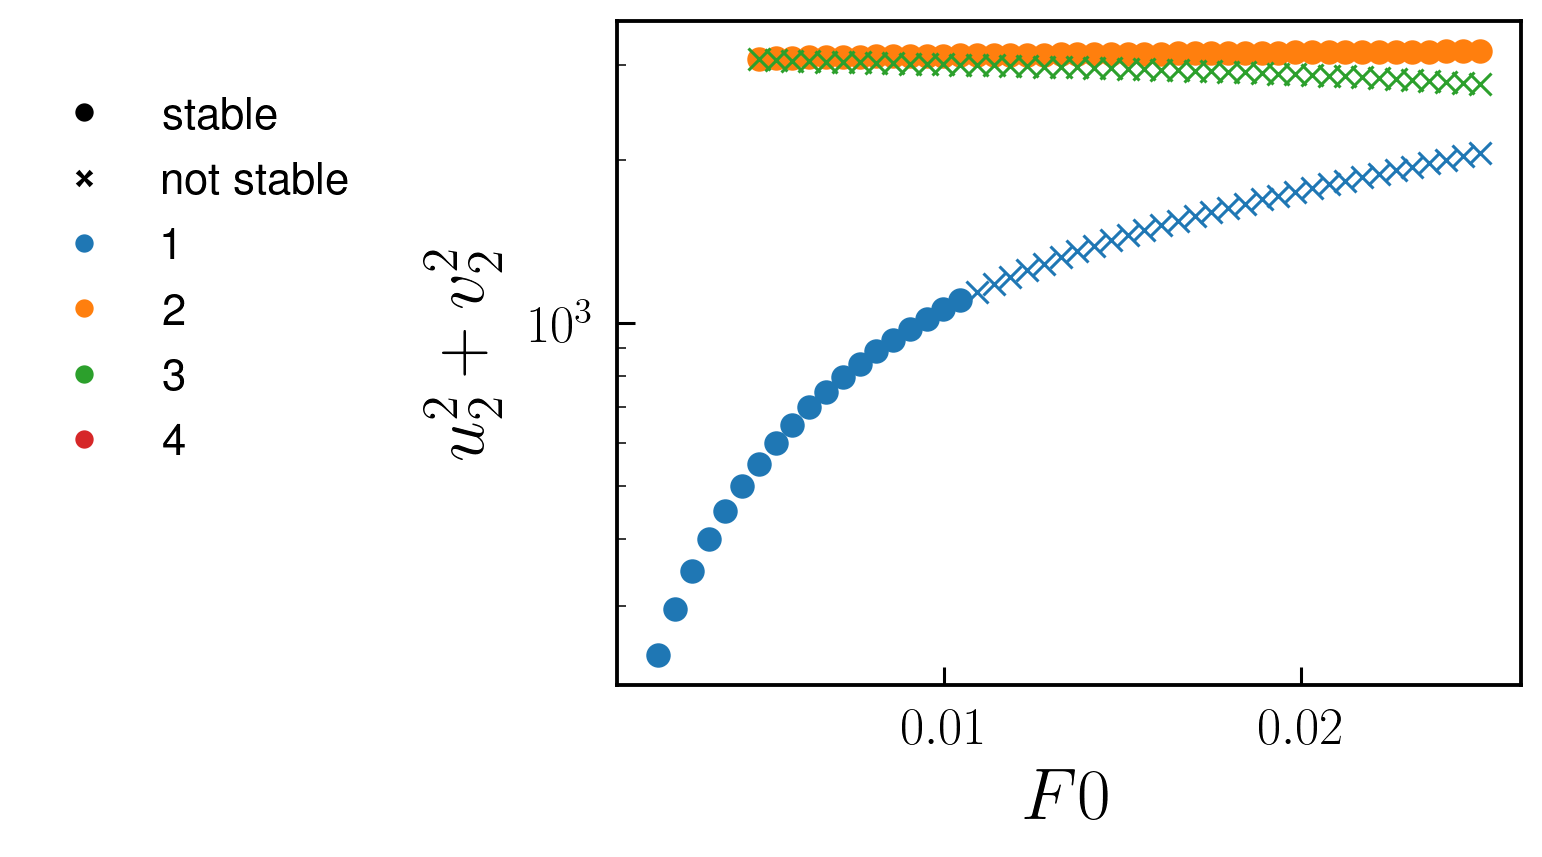

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/hrochan/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [5]:
plot(solutions, x="F0", y="u2^2 + v2^2", yscale=:log);
#HarmonicBalance.savefig("asym.png")

In [6]:
import HarmonicBalance.TimeEvolution: ODEProblem, DifferentialEquations.solve, ParameterSweep
initial_state = solutions[1][1]

T = 2E6
sweep = ParameterSweep(F0 => (0.002, 0.011), (0,T))
TDproblem = ODEProblem(harmonic_eqs, initial_state, sweep=sweep, timespan=(0,2*T))
TDsoln = solve(TDproblem, saveat=1);

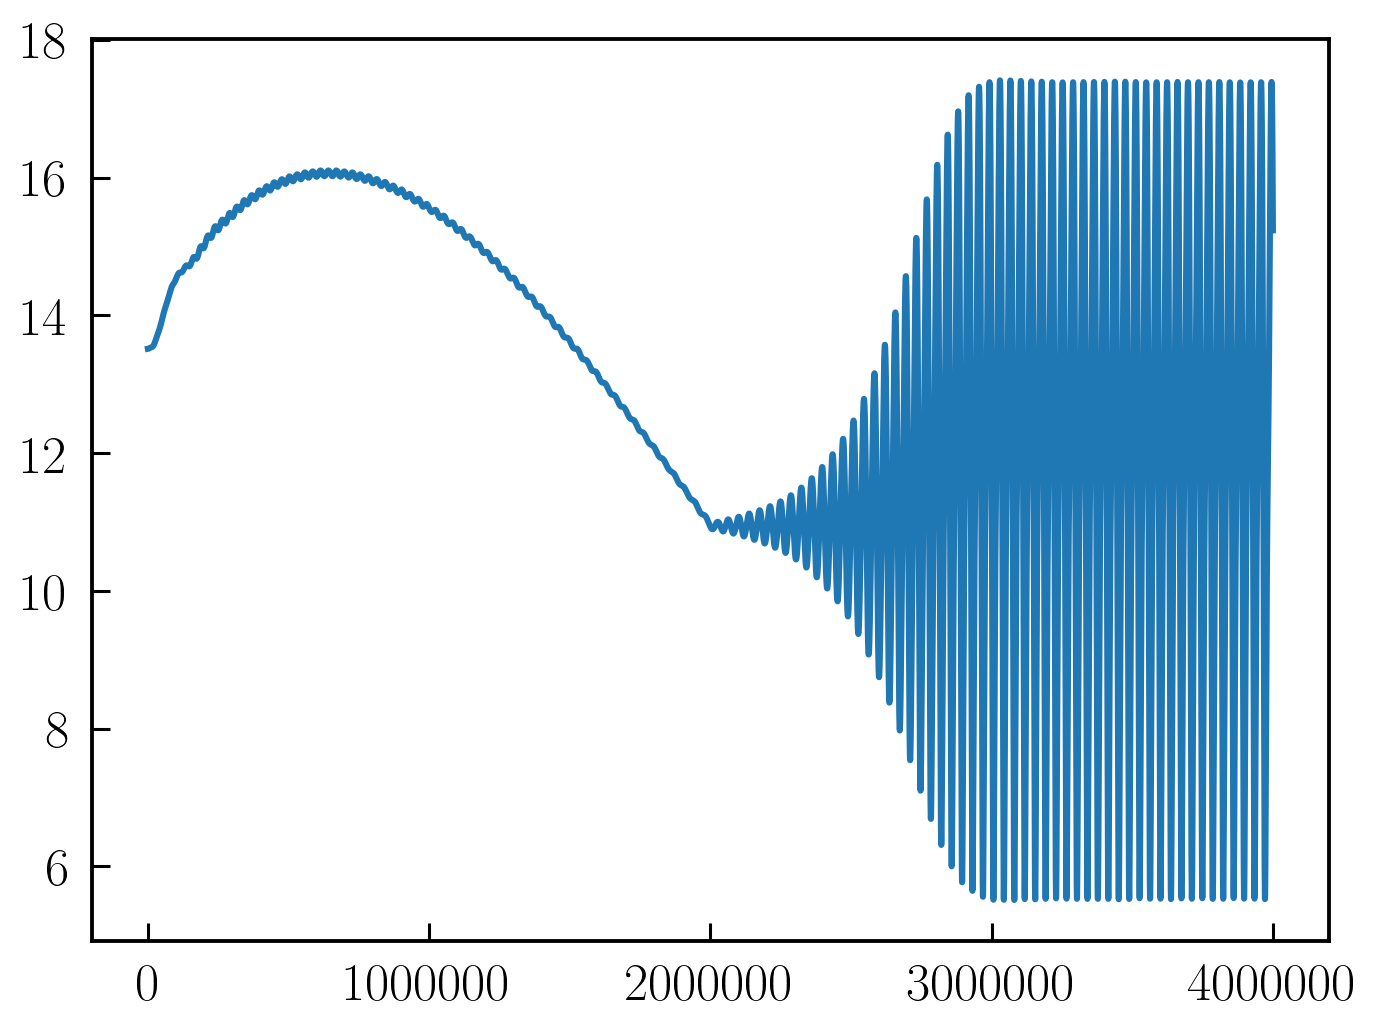

In [7]:
plot(TDsoln, "sqrt(u1^2 + v1^2)", harmonic_eqs);
#HarmonicBalance.xlabel("time", fontsize=24)
#HarmonicBalance.ylabel(HarmonicBalance.latexify("u_1"), fontsize=24)

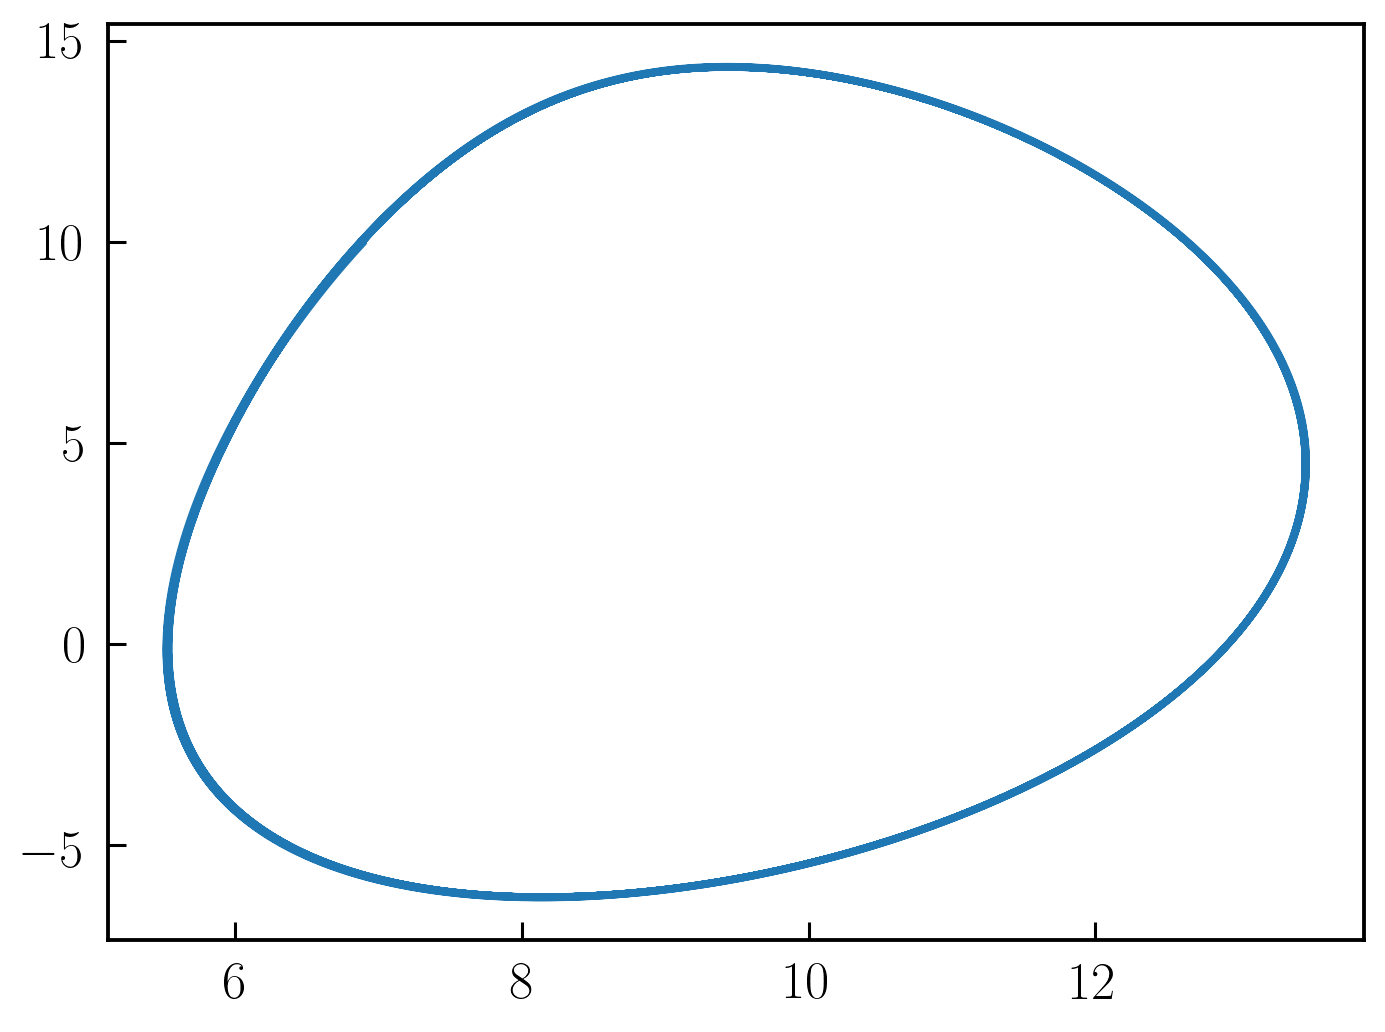

In [8]:
u(i) = getindex.(TDsoln.u, i)[Int(1.5*T):end]
plot(u(1), u(2))
plot(u(3), u(4));
#HarmonicBalance.xlabel(HarmonicBalance.latexify("u_1, u_2"), fontsize=24)
#HarmonicBalance.ylabel(HarmonicBalance.latexify("v_1, v_2"), fontsize=24)